## Objective = Build a recommendation system to recommend products to customers based on the their previous ratings for other products.

## Load Libraries and Data

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Loading libraries
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import re
import seaborn as sns

In [2]:
#Loading data
ratings = pd.read_csv('ratings_Electronics.csv')
ratings.columns = ['user_ID', 'item_id', 'Rating', 'timestamp']

In [3]:
print(ratings.shape)

(7824481, 4)


In [5]:
ratings.head()

,user_ID,item_id,Rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [6]:
ratings.drop(['timestamp'],axis=1,inplace=True)

In [7]:
ratings.head()

,user_ID,item_id,Rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [9]:
ratings.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rating,7824481.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


In [10]:
ratings.Rating.unique()

array([5., 1., 3., 2., 4.])

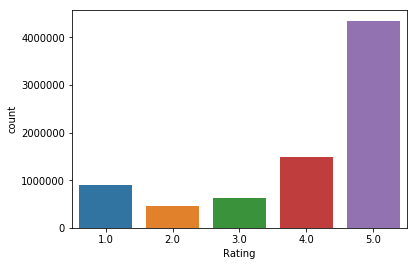

In [12]:
%matplotlib inline
sns.countplot(data=ratings, x='Rating')

# Popularity based recommendations

In [14]:
ratings.groupby('item_id')['Rating'].mean().head()

item_id
0321732944    5.000000
0439886341    1.666667
0511189877    4.500000
0528881469    2.851852
0558835155    3.000000
Name: Rating, dtype: float64

In [15]:
ratings.groupby('item_id')['Rating'].mean().sort_values(ascending=False).head()

item_id
BT008V9J9U    5.0
B0058PRC0S    5.0
B0058ORBFU    5.0
B0058OQ9Q2    5.0
B0058OKSMS    5.0
Name: Rating, dtype: float64

In [17]:
ratings.groupby('item_id')['Rating'].count().sort_values(ascending=False).head()

item_id
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: Rating, dtype: int64

In [20]:
ratings_mean_count = pd.DataFrame(ratings.groupby('item_id')['Rating'].mean()) 

In [21]:
ratings_mean_count['rating_counts'] = pd.DataFrame(ratings.groupby('item_id')['Rating'].count()) 

In [22]:
ratings_mean_count.sort_values('rating_counts',ascending=False).head()

,Rating,rating_counts
item_id,,
B0074BW614,4.491504,18244
B00DR0PDNE,3.931020,16454
B007WTAJTO,4.424005,14172
B0019EHU8G,4.754497,12285
B006GWO5WK,4.314657,12226


### **The popularity based recommendations above are made more relevant by sorting on the rating counts. Without this sorting the recommendations do not indicate popularity of the items**

# Collaborative Filtering Based Recommendation Systems

## a. For more accurate results only consider users who have rated atleast 50 items

In [27]:
counts1 = ratings['user_ID'].value_counts()
# print(counts1)
ratings_CF = ratings[ratings['user_ID'].isin(counts1[counts1 >= 50].index)]

In [28]:
ratings_CF.head()

,user_ID,item_id,Rating
117,AT09WGFUM934H,0594481813,3.0
177,A17HMM1M7T9PJ1,0970407998,4.0
630,A3TAS1AG6FMBQW,0972683275,5.0
1776,A18S2VGUH9SCV5,1400501776,4.0
2161,A5JLAU2ARJ0BO,1400532655,1.0


In [30]:
ratings_CF.shape

(44209, 3)

## b. Generate matrix table 

In [32]:
ratings_matrix = ratings.pivot(index='user_ID', columns='item_id', values='Rating').fillna(0)
user_ID = ratings_matrix.index
item_id = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()

(289, 22635)


item_id,0594481813,0970407998,0972683275,1400501776,1400532655,1400599997,1400699169,1685560148,7562434166,787988002X,...,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_ID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10PEXB6XAQ5XF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10Y058K7B96C6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10ZFE6YE0UHW8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Since NaNs cannot be handled by training algorithms, replacing these by 0, which indicates absence of ratings

## c. Generate the predicted ratings using SVD with no.of singular values to be 50


In [33]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(ratings_matrix, k = 50)

In [34]:
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = ratings_matrix.columns)

In [35]:
preds_df.head()

item_id,0594481813,0970407998,0972683275,1400501776,1400532655,1400599997,1400699169,1685560148,7562434166,787988002X,...,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.007273,0.001249,-0.024354,0.019858,0.007163,0.000739,0.012744,0.018462,0.005363,-0.003601,...,-0.055311,0.322925,-0.005588,-0.077080,-0.141806,-0.131544,0.013394,-0.198731,0.067938,0.001584
1,0.002485,-0.002452,0.057358,0.040406,-0.004640,0.000436,0.014649,0.013111,-0.000113,0.010802,...,0.006710,-0.105079,-0.009598,0.048149,0.026633,-0.012872,-0.029599,-0.022377,-0.034546,0.008466
2,0.000950,0.000487,0.119640,0.002175,0.000435,0.000086,-0.011196,0.014611,0.000064,-0.007642,...,-0.037576,0.235628,0.019401,-0.000993,0.103821,-0.040986,0.039064,0.084783,-0.038712,0.037797
3,-0.004321,-0.001464,0.105522,0.038826,-0.006237,-0.000095,-0.052618,-0.005630,0.005933,0.017571,...,-0.044521,0.123957,0.019767,0.044702,0.021392,-0.113093,0.015574,0.173706,-0.042632,-0.032504
4,0.008672,0.002921,0.079571,0.018170,-0.003324,0.000593,0.055773,0.017284,0.004907,0.015156,...,-0.055204,0.177769,0.001409,0.128439,0.052704,-0.059792,-0.016654,0.051093,-0.051577,-0.014446


# User Based - Collaborative filtering

#### Take a particular user_id

In [36]:
user_id = 2

In [37]:
userID = ratings_matrix.iloc[user_id-1, :].name
userID

'A100WO06OQR8BQ'

In [38]:
preds_df.shape

(289, 22635)

In [39]:
sorted_user_predictions = preds_df.iloc[user_id].sort_values(ascending=False)

In [40]:
len(sorted_user_predictions)

22635

In [42]:
# Get all user interacted books
user_data = ratings_CF[ratings_CF.user_ID == (userID)]

In [43]:
user_data.head()

,user_ID,item_id,Rating
31120,A100WO06OQR8BQ,B00002EQCW,5.0
47870,A100WO06OQR8BQ,B00004TDRH,5.0
177295,A100WO06OQR8BQ,B00006BBAC,5.0
184917,A100WO06OQR8BQ,B00006HSYC,5.0
208429,A100WO06OQR8BQ,B00006RVPW,5.0


In [44]:
user_data.shape

(132, 3)

In [46]:
print ('User {0} has already rated {1} items.'.format(userID, user_data.shape[0]))

User A100WO06OQR8BQ has already rated 132 items.


In [47]:
recommendations = (sorted_user_predictions).reset_index().rename(columns = {user_id: 'Predictions'})

In [48]:
recommendations.shape

(22635, 2)

In [49]:
recommendations.head()

,item_id,Predictions
0,B0079UAT0A,1.167344
1,B00BOHNYTW,1.103231
2,B000N99BBC,0.972008
3,B004CLYEFK,0.961307
4,B00825BZUY,0.888785


# Get top 5 recommendation for above given userID

In [51]:
recommendations.sort_values('Predictions', ascending = False).iloc[:5, :]

,item_id,Predictions
0,B0079UAT0A,1.167344
1,B00BOHNYTW,1.103231
2,B000N99BBC,0.972008
3,B004CLYEFK,0.961307
4,B00825BZUY,0.888785


# Evaluate the model - RMSE

## <font color=blue> **Note - Since on my machine *scikit-surprise* in not downloadable, I have tried the following code on Google CoLab.**</font>  

In [71]:
#! pip install scikit-surprise

  Using cached https://files.pythonhosted.org/packages/f5/da/b5700d96495fb4f092be497f02492768a3d96a3f4fa2ae7dea46d4081cfa/scikit-surprise-1.1.0.tar.gz
  Running setup.py bdist_wheel for scikit-surprise: started
  Running setup.py bdist_wheel for scikit-surprise: finished with status 'error'
  Complete output from command C:\ProgramData\Anaconda3\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\KADAMAB1\\AppData\\Local\\Temp\\1\\pip-install-qqe9_74p\\scikit-surprise\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d C:\Users\KADAMAB1\AppData\Local\Temp\1\pip-wheel-v9ao0ly3 --python-tag cp36:
  C:\ProgramData\Anaconda3\lib\distutils\dist.py:261: UserWarning: Unknown distribution option: 'long_description_content_type'
    warnings.warn(msg)
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.6
  creating build\lib

  Failed building wheel for scikit-surprise
distributed 1.21.8 requires msgpack, which is not installed.
Command "C:\ProgramData\Anaconda3\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\KADAMAB1\\AppData\\Local\\Temp\\1\\pip-install-qqe9_74p\\scikit-surprise\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record C:\Users\KADAMAB1\AppData\Local\Temp\1\pip-record-b8fx6ywl\install-record.txt --single-version-externally-managed --compile" failed with error code 1 in C:\Users\KADAMAB1\AppData\Local\Temp\1\pip-install-qqe9_74p\scikit-surprise\
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

#### Since we are using custom data i.e. not bulitin data, need to use the Reader class from the surprise.dataset.load_from_df method

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_CF[['user_ID', 'item_id', 'Rating']], reader)

In [ ]:
trainset, testset = train_test_split(data, test_size=.30)

For user-based collaborative filtering we need to pass user_based = true and use it to switch between user-based or item-based collaborative filtering.

In [ ]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

In [ ]:
test_pred = algo.test(testset)

In [ ]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

### User-based Model : Test Set
#### RMSE: 1.0621
#### 1.0621323073152356

# Description of criterion

For the Popularity based recommendations grouping of the user ratings in important. Without user characteristics the recommendations will be same for all the users due to the high inlfuence on the item popularity.

For the Collaborative Filtering, it is important from computaion as well from recommendation perspective that the data is made sparse. The fact that the given data has 7.2 million rows indicates that this is a huge dataset.
The criteria applired for reducing this data is 
1) All user may not have rated all items
2) The user which have given ratings to atleast 50 items will influence the recommnedations given to users with similar characteristics.
3) The items thus recommended to a user will be close to the user characteristics there by enhancing the user experience and leading to a purchase.


---------------------------------------------------END------------------------------------------------------------